In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd


# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )




## loaded data

In [2]:
Phase_1 = convert_tsf_to_dataframe("phase_1_data.tsf")
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = Phase_1
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [3]:
dataset = loaded_data.explode('series_value')
dataset

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,606.0
0,Building0,2016-07-03 21:30:00,606.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,25.28
11,Solar5,2019-01-15 13:00:00,25.3
11,Solar5,2019-01-15 13:00:00,28.62
11,Solar5,2019-01-15 13:00:00,31.94


## solor data split

In [4]:
solar_0 = dataset.loc[dataset['series_name']=='Solar0']

In [5]:
import datetime

# Input start date
start_date_str = '25/04/2020 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][6])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_0['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_19441/2664081120.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_0['start_timestamp']=datetime_column


In [6]:
solar_0 = solar_0.rename(columns={"series_name": "building_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_0 = solar_0[solar_0.power_output != "NaN"]
solar_0["power_output"] = pd.to_numeric(solar_0["power_output"])
solar_0

,building_no,timestamp,power_output
6,Solar0,2020-04-25 14:00:00,0.00
6,Solar0,2020-04-25 14:15:00,0.00
6,Solar0,2020-04-25 14:30:00,0.00
6,Solar0,2020-04-25 14:45:00,0.00
6,Solar0,2020-04-25 15:00:00,0.00
...,...,...,...
6,Solar0,2020-09-30 22:45:00,29.67
6,Solar0,2020-09-30 23:00:00,29.94
6,Solar0,2020-09-30 23:15:00,34.02
6,Solar0,2020-09-30 23:30:00,38.10


In [7]:
solar_1 = dataset.loc[dataset['series_name']=='Solar1']

In [8]:
import datetime

# Input start date
start_date_str = '31/12/2018 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][7])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_1['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_19441/2969204059.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_1['start_timestamp']=datetime_column


In [9]:
solar_1 = solar_1.rename(columns={"series_name": "building_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_1 = solar_1[solar_1.power_output != "NaN"]
solar_1["power_output"] = pd.to_numeric(solar_1["power_output"])
solar_1

,building_no,timestamp,power_output
7,Solar1,2018-12-31 13:00:00,0.00
7,Solar1,2018-12-31 13:15:00,0.00
7,Solar1,2018-12-31 13:30:00,0.00
7,Solar1,2018-12-31 13:45:00,0.00
7,Solar1,2018-12-31 14:00:00,0.00
...,...,...,...
7,Solar1,2020-09-30 22:45:00,6.68
7,Solar1,2020-09-30 23:00:00,6.71
7,Solar1,2020-09-30 23:15:00,8.13
7,Solar1,2020-09-30 23:30:00,9.55


In [10]:
solar_2 = dataset.loc[dataset['series_name']=='Solar2']

In [11]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][8])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_2['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_19441/2501473815.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_2['start_timestamp']=datetime_column


In [12]:
solar_2 = solar_2.rename(columns={"series_name": "building_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_2 = solar_2[solar_2.power_output != "NaN"]
solar_2["power_output"] = pd.to_numeric(solar_2["power_output"])
solar_2

,building_no,timestamp,power_output
8,Solar2,2019-06-05 14:00:00,0.00
8,Solar2,2019-06-05 14:15:00,0.00
8,Solar2,2019-06-05 14:30:00,0.00
8,Solar2,2019-06-05 14:45:00,0.00
8,Solar2,2019-06-05 15:00:00,0.00
...,...,...,...
8,Solar2,2020-09-30 22:45:00,6.34
8,Solar2,2020-09-30 23:00:00,6.39
8,Solar2,2020-09-30 23:15:00,7.71
8,Solar2,2020-09-30 23:30:00,9.03


In [13]:
solar_3 = dataset.loc[dataset['series_name']=='Solar3']

In [14]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][9])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_3['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_19441/2686233820.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_3['start_timestamp']=datetime_column


In [15]:
solar_3 = solar_3.rename(columns={"series_name": "building_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_3 = solar_3[solar_3.power_output != "NaN"]
solar_3["power_output"] = pd.to_numeric(solar_3["power_output"])
solar_3

,building_no,timestamp,power_output
9,Solar3,2019-06-05 14:00:00,0.00
9,Solar3,2019-06-05 14:15:00,0.00
9,Solar3,2019-06-05 14:30:00,0.00
9,Solar3,2019-06-05 14:45:00,0.00
9,Solar3,2019-06-05 15:00:00,0.00
...,...,...,...
9,Solar3,2020-09-30 22:45:00,5.49
9,Solar3,2020-09-30 23:00:00,5.65
9,Solar3,2020-09-30 23:15:00,6.83
9,Solar3,2020-09-30 23:30:00,8.02


In [16]:
solar_4 = dataset.loc[dataset['series_name']=='Solar4']

In [17]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][10])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_4['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_19441/601097210.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_4['start_timestamp']=datetime_column


In [18]:
solar_4 = solar_4.rename(columns={"series_name": "building_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_4 = solar_4[solar_4.power_output != "NaN"]
solar_4["power_output"] = pd.to_numeric(solar_4["power_output"])
solar_4

,building_no,timestamp,power_output
10,Solar4,2019-06-05 14:00:00,0.00
10,Solar4,2019-06-05 14:15:00,0.00
10,Solar4,2019-06-05 14:30:00,0.00
10,Solar4,2019-06-05 14:45:00,0.00
10,Solar4,2019-06-05 15:00:00,0.00
...,...,...,...
10,Solar4,2020-09-30 22:45:00,4.55
10,Solar4,2020-09-30 23:00:00,4.57
10,Solar4,2020-09-30 23:15:00,5.32
10,Solar4,2020-09-30 23:30:00,6.08


In [19]:
solar_5 = dataset.loc[dataset['series_name']=='Solar5']
# solar_5

In [20]:
import datetime

# Input start date
start_date_str = '15/01/2019 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][11])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_5['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_19441/2778311694.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_5['start_timestamp']=datetime_column


In [21]:
solar_5 = solar_5.rename(columns={"series_name": "building_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_5 = solar_5[solar_5.power_output != "NaN"]
solar_5["power_output"] = pd.to_numeric(solar_5["power_output"])
solar_5

,building_no,timestamp,power_output
11,Solar5,2019-01-15 13:00:00,0.00
11,Solar5,2019-01-15 13:15:00,0.00
11,Solar5,2019-01-15 13:30:00,0.00
11,Solar5,2019-01-15 13:45:00,0.00
11,Solar5,2019-01-15 14:00:00,0.00
...,...,...,...
11,Solar5,2020-09-30 22:45:00,25.28
11,Solar5,2020-09-30 23:00:00,25.30
11,Solar5,2020-09-30 23:15:00,28.62
11,Solar5,2020-09-30 23:30:00,31.94


In [22]:
solar_3.isna().any()

building_no     False
timestamp       False
power_output    False
dtype: bool

In [23]:
def time_change_data(timeseries,solar_number):
    timestamp_series= pd.to_datetime(timeseries)

    # Extract the day and time parts using dt accessor
    day_part = timestamp_series.dt.strftime("%Y-%m-%d")
    time_part= timestamp_series.dt.strftime("%H:%M:%S")

    # Create a DataFrame to display the results
    result_df= pd.DataFrame({
        "Day": day_part,
        "Solar": solar_number["power_output"]
    })
    result_df_sum=result_df.groupby('Day').sum()
    return result_df_sum



# solor power output graph

## solar 0 power output graph

<AxesSubplot:xlabel='Day'>

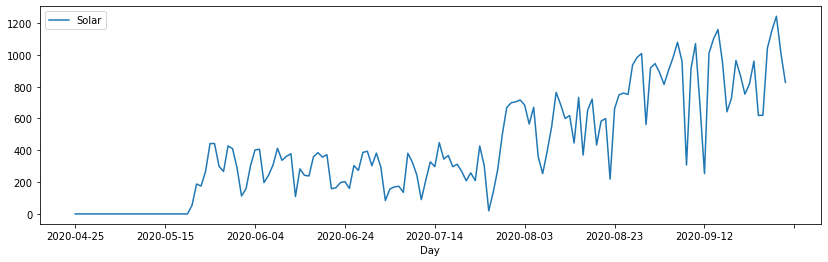

In [24]:
timestamp_series0 = pd.Series(solar_0['timestamp'])
result_df_sum0=time_change_data(timestamp_series0,solar_0)
result_df_sum0.plot.line(figsize=(14,4))

## solar 1 power output graph

<AxesSubplot:xlabel='Day'>

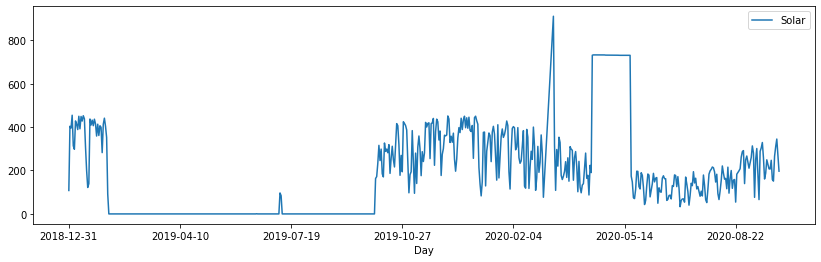

In [25]:
timestamp_series1 = pd.Series(solar_1['timestamp'])
result_df_sum1=time_change_data(timestamp_series1,solar_1)
result_df_sum1.plot.line(figsize=(14,4))

## solar 2 power output graph

<AxesSubplot:xlabel='Day'>

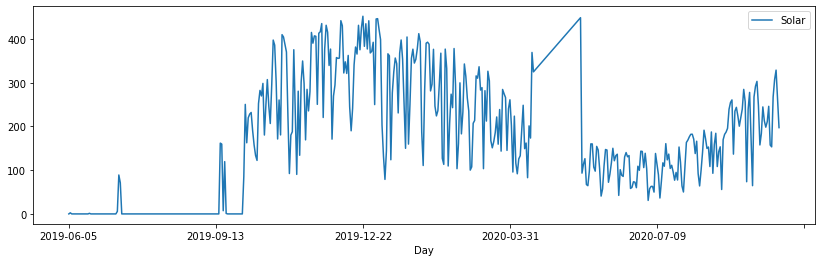

In [26]:
timestamp_series2 = pd.Series(solar_2['timestamp'])
result_df_sum2=time_change_data(timestamp_series2,solar_2)
result_df_sum2.plot.line(figsize=(14,4))

## solar 3 power output graph

<AxesSubplot:xlabel='Day'>

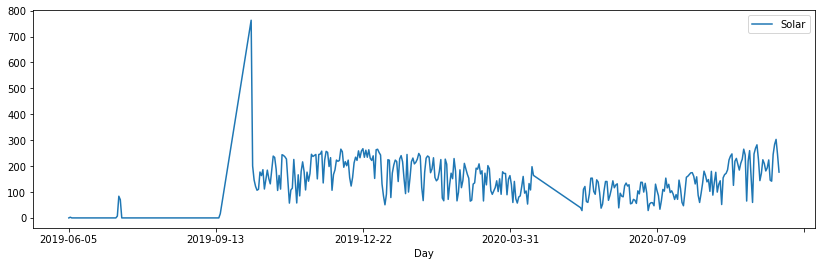

In [27]:
timestamp_series3 = pd.Series(solar_3['timestamp'])
result_df_sum3=time_change_data(timestamp_series3,solar_3)
result_df_sum3.plot.line(figsize=(14,4))

In [28]:
start_date = "2020-04-16"
end_date = "2020-05-19"
solar2_day = solar_2.query('timestamp >= @start_date & timestamp <= @end_date')
solar_3.isna().sum()

building_no     0
timestamp       0
power_output    0
dtype: int64

## solar 4 power output graph

<AxesSubplot:xlabel='Day'>

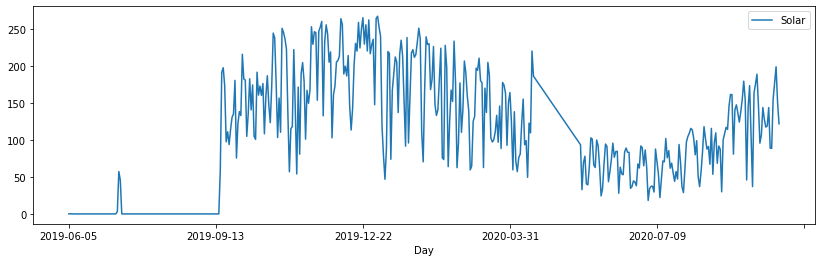

In [29]:
timestamp_series4 = pd.Series(solar_4['timestamp'])
result_df_sum4=time_change_data(timestamp_series4,solar_4)
result_df_sum4.plot.line(figsize=(14,4))

## solar 5 power output graph

<AxesSubplot:xlabel='Day'>

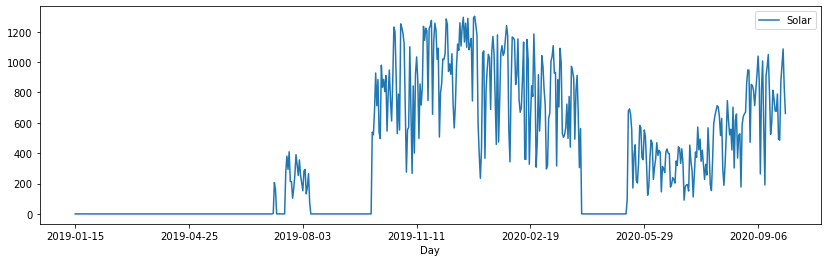

In [30]:
timestamp_series5 = pd.Series(solar_5['timestamp'])
result_df_sum5=time_change_data(timestamp_series5,solar_5)
result_df_sum5.plot.line(figsize=(14,4))

In [31]:
solar_5

,building_no,timestamp,power_output
11,Solar5,2019-01-15 13:00:00,0.00
11,Solar5,2019-01-15 13:15:00,0.00
11,Solar5,2019-01-15 13:30:00,0.00
11,Solar5,2019-01-15 13:45:00,0.00
11,Solar5,2019-01-15 14:00:00,0.00
...,...,...,...
11,Solar5,2020-09-30 22:45:00,25.28
11,Solar5,2020-09-30 23:00:00,25.30
11,Solar5,2020-09-30 23:15:00,28.62
11,Solar5,2020-09-30 23:30:00,31.94
